**Sample ID**: CM206_base


**Query**: I have a birthday card for my aunt that needed to be picked up by the mail carrier today. Check if Drake put the card in the front door mailbox, and if he did, text on Slack  "Thanks for putting the card in the mailbox, Drake! 😊" in the channel "Family_Chat".


**DB Type**: Base Case


**Case Description**: The camera shows a man on the front porch that appears to be Drake. It appears that Drake placed the card in the mailbox, therefore send a Slack message: "Thanks for putting the card in the mailbox, Drake! 😊" in the channel "Family_Chat".


**Global/Context Variables:**

- slack_channel = "Family_Chat"
- slack_message = "Thanks for putting the card in the mailbox, Drake! 😊"


**APIs:**
- slack
- sdm

# Set Up

## Download relevant files

In [3]:
import io
import os
import sys
import zipfile
import shutil
import re
from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload

VERSION = "0.1.4"  # Pass the version of the API
CONTENT_DIR = '/content'
APIS_DIR = os.path.join(CONTENT_DIR, 'APIs')
DBS_DIR = os.path.join(CONTENT_DIR, 'DBs')
SCRIPTS_DIR = os.path.join(CONTENT_DIR, 'Scripts')
FC_DIR = os.path.join(CONTENT_DIR, 'Schemas')
ZIP_PATH = os.path.join(CONTENT_DIR, f'APIs_V{VERSION}.zip')

APIS_FOLDER_ID = '1QpkAZxXhVFzIbm8qPGPRP1YqXEvJ4uD4'
ITEMS_TO_EXTRACT = ['APIs/', 'DBs/', 'Scripts/', 'Schemas/']

# Cleanup
for path in [APIS_DIR, DBS_DIR, SCRIPTS_DIR, FC_DIR, ZIP_PATH]:
    if os.path.exists(path):
        if os.path.isdir(path):
            shutil.rmtree(path)
        else:
            os.remove(path)

# Auth
auth.authenticate_user()
drive_service = build('drive', 'v3')

def download_drive_file(service, file_id, output_path, file_name=None, show_progress=True):
    request = service.files().get_media(fileId=file_id)
    with io.FileIO(output_path, 'wb') as fh:
        downloader = MediaIoBaseDownload(fh, request)
        done = False
        while not done:
            status, done = downloader.next_chunk()
            if show_progress:
                print(f"Download progress: {int(status.progress() * 100)}%")

print(f"Searching for APIs zip file with version {VERSION} in folder: {APIS_FOLDER_ID}...")
apis_file_id = None
try:
    query = f"'{APIS_FOLDER_ID}' in parents and trashed=false"
    results = drive_service.files().list(q=query, fields="files(id, name)").execute()
    for file in results.get('files', []):
        if file['name'].lower() == f'apis_v{VERSION.lower()}.zip':
            apis_file_id = file['id']
            print(f"Found: {file['name']} (ID: {apis_file_id})")
            break
except Exception as e:
    print(f"Error listing files: {e}")

if not apis_file_id:
    sys.exit(f"❌ APIs zip V{VERSION} not found.")

print(f"Downloading APIs zip {apis_file_id}...")
download_drive_file(drive_service, apis_file_id, ZIP_PATH)

print(f"Extracting {ZIP_PATH}...")
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    for member in zip_ref.namelist():
        if any(member.startswith(p) for p in ITEMS_TO_EXTRACT):
            zip_ref.extract(member, CONTENT_DIR)

os.remove(ZIP_PATH)

if os.path.exists(APIS_DIR):
    sys.path.append(APIS_DIR)

for p in [APIS_DIR, DBS_DIR, SCRIPTS_DIR]:
    print(f"{'✅' if os.path.exists(p) else '❌'} {p}")

# PWS: Copy pws_image_data folder in /content/pws_image_data
print(f"\nDownloading all files from pws_images_data Drive folder.")
IMAGES_ZIP_ID = '1MlgE9LnFA221ARh9l4nbF1yGc215KDN_'
IMAGES_ZIP_PATH = os.path.join(CONTENT_DIR, 'pws_images_data.zip')
download_drive_file(drive_service, IMAGES_ZIP_ID, IMAGES_ZIP_PATH, file_name='pws_images_data.zip')

print(f"Extracting images from {IMAGES_ZIP_PATH} to {CONTENT_DIR}...")
try:
    with zipfile.ZipFile(IMAGES_ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(CONTENT_DIR)

except zipfile.BadZipFile:
    print(f"Error: The downloaded file at {IMAGES_ZIP_PATH} is not a valid zip file.")
    sys.exit("Invalid zip file downloaded.")
except Exception as e:
    print(f"An error occurred during extraction: {e}")
    sys.exit("Extraction failed.")

if os.path.exists(IMAGES_ZIP_PATH):
    os.remove(IMAGES_ZIP_PATH)

Searching for APIs zip file with version 0.1.4 in folder: 1QpkAZxXhVFzIbm8qPGPRP1YqXEvJ4uD4...
Found: APIs_V0.1.4.zip (ID: 1TnAaWGfVrMxWTilyhy46-Aue_bh0XkNk)
Download progress: 100%
Extracting /content/APIs_V0.1.4.zip...
✅ /content/APIs
✅ /content/DBs
✅ /content/Scripts

Download progress: 78%
Download progress: 100%
Extracting images from /content/pws_images_data.zip to /content...


## Install Dependencies and Clone Repositories

In [4]:
!pip install uv
!uv pip install -r /content/APIs/requirements.txt
!uv pip install jsonpath_ng

Using Python 3.12.12 environment at: /usr
Audited 50 packages in 142ms
Using Python 3.12.12 environment at: /usr
Audited 1 package in 125ms


## Import APIs and initiate DBs

In [13]:
scenario_db = {'environment': {'home_assistant': {'devices': {'DOOR_001': {'attributes': {'auto_close_enabled': 'Yes',
                                                                            'company': 'SecureGuard',
                                                                            'model': 'D-Alpha900',
                                                                            'serial_number': 'SG092384',
                                                                            'state': 'Locked'},
                                                             'name': 'Front '
                                                                     'Door',
                                                             'type': 'Door'},
                                                'DOOR_002': {'attributes': {'auto_close_enabled': 'Yes',
                                                                            'company': 'SecureGuard',
                                                                            'model': 'D-Beta750',
                                                                            'serial_number': 'FL902134',
                                                                            'state': 'Locked'},
                                                             'name': 'Back '
                                                                     'Door',
                                                             'type': 'Door'},
                                                'LIGHT_001': {'attributes': {'brightness': 1.0,
                                                                             'company': 'Crompton',
                                                                             'model': '4Ft.22W',
                                                                             'serial_number': 'C564311',
                                                                             'state': 'On',
                                                                             'supports_color': 'No'},
                                                              'name': 'Living '
                                                                      'Room '
                                                                      'Light 1',
                                                              'type': 'Light'},
                                                'LIGHT_002': {'attributes': {'brightness': 1.0,
                                                                             'company': 'Crompton',
                                                                             'model': '4Ft.22W',
                                                                             'serial_number': 'C1689574',
                                                                             'state': 'Off',
                                                                             'supports_color': 'No'},
                                                              'name': 'Living '
                                                                      'Room '
                                                                      'Light 2',
                                                              'type': 'Light'},
                                                'LIGHT_003': {'attributes': {'brightness': 0.8,
                                                                             'company': 'Crompton',
                                                                             'model': '3Ft.15W',
                                                                             'serial_number': 'C551233',
                                                                             'state': 'On',
                                                                             'supports_color': 'No'},
                                                              'name': 'Kitchen '
                                                                      'Light',
                                                              'type': 'Light'},
                                                'LIGHT_004': {'attributes': {'brightness': 1.0,
                                                                             'color': '#FFFFFF',
                                                                             'company': 'Crompton '
                                                                                        'Multi-Color',
                                                                             'model': '4Ft.22W '
                                                                                      '- '
                                                                                      '3 '
                                                                                      'in '
                                                                                      '1',
                                                                             'serial_number': 'C09781',
                                                                             'state': 'Off',
                                                                             'supports_color': 'Yes'},
                                                              'name': 'Kids '
                                                                      'Room '
                                                                      'Light',
                                                              'type': 'Light'},
                                                'SPK_001': {'attributes': {'audio_mode': 'Movie',
                                                                           'company': 'JBL',
                                                                           'model': 'JBLBOOMBOX3BLKUK',
                                                                           'serial_number': 'JBLBOOM3_123982u',
                                                                           'state': 'Off',
                                                                           'volume': 100},
                                                            'name': 'Kitchen '
                                                                    'Speaker',
                                                            'type': 'Speaker'},
                                                'TV_001': {'attributes': {'brightness': 70,
                                                                          'company': 'Samsung',
                                                                          'is_muted': 'No',
                                                                          'model': '1.63 '
                                                                                   'm '
                                                                                   '(65) '
                                                                                   'QN900F '
                                                                                   'Neo '
                                                                                   'QLED '
                                                                                   '8K '
                                                                                   'Smart '
                                                                                   'TV',
                                                                          'serial_number': 'SSTVSN8977D',
                                                                          'state': 'On',
                                                                          'volume': 65},
                                                           'name': 'Living '
                                                                   'Room TV',
                                                           'type': 'Television'}}},
                 'sdm': {'devices': {'CAM_001': {'attributes': {'company': 'Google',
                                                                'model': 'Google '
                                                                         'Nest '
                                                                         'Cam '
                                                                         'IQ '
                                                                         'Outdoor',
                                                                'parent': 'enterprises/family-house-0903/structures/STRCT1/rooms/OUT1',
                                                                'serial_number': 'GN-IQ-O-089312',
                                                                'state': 'On'},
                                                 'name': 'Front Porch',
                                                 'type': 'Camera'},
                                     'CAM_002': {'attributes': {'company': 'Google',
                                                                'model': 'Google '
                                                                         'Nest '
                                                                         'Cam '
                                                                         'Indoor',
                                                                'parent': 'enterprises/family-house-0903/structures/STRCT2/rooms/ROOM1',
                                                                'serial_number': 'GN-I-70983412',
                                                                'state': 'On'},
                                                 'name': 'Living Room Camera',
                                                 'type': 'Camera'},
                                     'CAM_003': {'attributes': {'company': 'Google',
                                                                'model': 'Google '
                                                                         'Nest '
                                                                         'Cam '
                                                                         'Indoor',
                                                                'parent': 'enterprises/family-house-0903/structures/STRCT2/rooms/ROOM2',
                                                                'serial_number': 'GN-I-897321',
                                                                'state': 'On'},
                                                 'name': 'Kids Room Camera',
                                                 'type': 'Camera'},
                                     'CAM_004': {'attributes': {'company': 'Google',
                                                                'model': 'Google '
                                                                         'Nest '
                                                                         'Cam '
                                                                         'IQ '
                                                                         'Outdoor',
                                                                'parent': 'enterprises/family-house-0903/structures/STRCT1/rooms/OUT2',
                                                                'serial_number': 'GN-IQ-O-1578969',
                                                                'state': 'On'},
                                                 'name': 'Back Door Camera',
                                                 'type': 'Camera'},
                                     'CAM_005': {'attributes': {'company': 'Google',
                                                                'model': 'Google '
                                                                         'Nest '
                                                                         'Cam '
                                                                         'IQ '
                                                                         'Outdoor',
                                                                'parent': 'enterprises/family-house-0903/structures/STRCT1/rooms/OUT3',
                                                                'serial_number': 'GN-IQ-O-98713',
                                                                'state': 'On'},
                                                 'name': 'Driveway Camera',
                                                 'type': 'Camera'}},
                         'structures': [{'name': 'enterprises/family-house-0903/structures/STRCT1',
                                         'traits': {'sdm.structures.traits.Info': {'customName': 'House '
                                                                                                 '- '
                                                                                                 'Outdoors'}}},
                                        {'name': 'enterprises/family-house-0903/structures/STRCT2',
                                         'traits': {'sdm.structures.traits.Info': {'customName': 'House '
                                                                                                 '- '
                                                                                                 'Indoors'}}}]}},
 'project_id': 'family-house-0903'}

image_map = {'cameras': {'CAM_001': [{'expected': 'Yes',
                          'image_path': './pws_image_data/052225 12_25.JPG'}],
             'CAM_002': [{'expected': 'No',
                          'image_path': './pws_image_data/May 22 2025 '
                                        '0600.jpg'}],
             'CAM_003': [{'expected': 'No',
                          'image_path': './pws_image_data/05-16-25 '
                                        '135634.jpg'}],
             'CAM_004': [{'expected': 'No',
                          'image_path': './pws_image_data/05202502_30_37.JPG'}],
             'CAM_005': [{'expected': 'No',
                          'image_path': './pws_image_data/Driveway_05_20_25 '
                                        '17_11.JPG'}]},
 'events': [{'camera_id': 'CAM_001',
             'image_path': './pws_image_data/052225 12_25.JPG',
             'timestamp': '2025-05-22 12:25:00',
             'trigger': 'Person'}]}


import json

with open("/content/scenario_db.json", "w") as f:
    json.dump(scenario_db, f)

with open("/content/image_map.json", "w") as f:
    json.dump(image_map, f)


import os
import json

import sdm
import slack

# Define context variable
slack_channel = "Family_Chat"
slack_message = "Thanks for putting the card in the mailbox, Drake! 😊"

# Initialize DBs
sdm.SimulationEngine.db.load_state(f"/content/scenario_db.json")
slack.SimulationEngine.db.load_state("/content/DBs/SlackDefaultDB.json")

# Print the DBs
print(f"SDM DB: {sdm.SimulationEngine.db.DB}")
print(f"Slack DB: {slack.SimulationEngine.db.DB}")

# Load image map for this task
with open("/content/image_map.json", "r") as f:
    image_map = json.load(f)

# Print the Image Map
print(f"Image Map: {image_map}")

# Reset states
sdm.devices.commands.reset_served_images()
sdm.SimulationEngine.db.reset_state_env()

# Initialize image map
sdm.SimulationEngine.db.update_state_dict(image_map)

# Create slack channel
slack.create_channel(slack_channel, is_private=True)

# Set events
sdm.SimulationEngine.events.set_cameras_events(image_map, sdm.SimulationEngine.db.DB.get("project_id", ""))

SDM DB: {'environment': {'home_assistant': {'devices': {'DOOR_001': {'attributes': {'auto_close_enabled': 'Yes', 'company': 'SecureGuard', 'model': 'D-Alpha900', 'serial_number': 'SG092384', 'state': 'Locked'}, 'name': 'Front Door', 'type': 'Door'}, 'DOOR_002': {'attributes': {'auto_close_enabled': 'Yes', 'company': 'SecureGuard', 'model': 'D-Beta750', 'serial_number': 'FL902134', 'state': 'Locked'}, 'name': 'Back Door', 'type': 'Door'}, 'LIGHT_001': {'attributes': {'brightness': 1.0, 'company': 'Crompton', 'model': '4Ft.22W', 'serial_number': 'C564311', 'state': 'On', 'supports_color': 'No'}, 'name': 'Living Room Light 1', 'type': 'Light'}, 'LIGHT_002': {'attributes': {'brightness': 1.0, 'company': 'Crompton', 'model': '4Ft.22W', 'serial_number': 'C1689574', 'state': 'Off', 'supports_color': 'No'}, 'name': 'Living Room Light 2', 'type': 'Light'}, 'LIGHT_003': {'attributes': {'brightness': 0.8, 'company': 'Crompton', 'model': '3Ft.15W', 'serial_number': 'C551233', 'state': 'On', 'suppo

# Initial Assertion
1. Assert that the "Family_Chat" slack channel exists.
2. Assert that  no message has been sent in the "Family_Chat" with message body "Thanks for putting the card in the mailbox, Drake! 😊".


In [14]:
import sdm
import slack
from Scripts.assertions_utils import *

# Define context variables
slack_channel = "Family_Chat"
slack_message = "Thanks for putting the card in the mailbox, Drake! 😊"

# 1. Assert that the "Family_Chat" slack channel exists.
channel_flag = False
slack_channels = slack.list_channels()

for channel in slack_channels.get("channels", []):
    if compare_strings(channel.get("name", ""), slack_channel):
        channel_flag = True
        break

assert channel_flag, f"Channel {slack_channel} does not exist."

# 2. Assert that no message has been sent in the "Family_Chat" channel with message body "Thanks for putting the card in the mailbox, Drake! 😊".
search_query = f"in:#{slack_channel} {slack_message}"
filtered_messages = slack.search_messages(search_query)

assert len(filtered_messages) == 0, (
    f"Found {len(filtered_messages)} Slack messages in #{slack_channel}, expected 0."
)


# Action
* Locate the Front Porch camera
* Access "Person" events on camera to see if Drake placed card in mailbox.
* The footage shows a man on the front porch; this appears to be Drake.
* Since it appears that Drake placed the card in the mailbox, text Drake on Slack: "Thanks for putting the card in the mailbox, babe! 😊" on channel "Family_Chat"

In [17]:
import sdm
import slack
import base64
from IPython.display import Image, display

def display_base64_image(image_base64):
    """Helper function to display a base 64 image"""
    base64_string = image_base64.split(':')[1].strip()

    try:
        missing_padding = len(base64_string) % 4
        if missing_padding:
            base64_string += '=' * (4 - missing_padding)
        image_data = base64.b64decode(base64_string)
    except Exception as e:
        print(f"Error decoding base64 string: {e}")
        image_data = None

    if image_data:
        display(Image(data=image_data))

# Define context variable
slack_channel = "Family_Chat"
slack_message = "Thanks for putting the card in the mailbox, Drake! 😊"

# 1. List all relevant devices
# List all sdm devices
sdm_devices = sdm.list_devices()
print(f"All available SDM devices: {sdm_devices}")

All available SDM devices: {'devices': [{'name': 'enterprises/family-house-0903/devices/CAM_001', 'type': 'sdm.devices.types.CAMERA', 'traits': {'sdm.devices.traits.CameraEventImage': {}, 'sdm.devices.traits.CameraImage': {'maxImageResolution': {'width': 1280, 'height': 960}}, 'sdm.devices.traits.CameraLiveStream': {'maxVideoResolution': {'width': 640, 'height': 480}, 'videoCodecs': ['H264'], 'audioCodecs': ['AAC'], 'supportedProtocols': ['RTSP']}, 'sdm.devices.traits.CameraMotion': {}, 'sdm.devices.traits.CameraPerson': {}, 'sdm.devices.traits.CameraSound': {}, 'sdm.devices.traits.Info': {'customName': 'Front Porch'}}, 'project_id': 'family-house-0903', 'parentRelations': [{'parent': 'enterprises/family-house-0903/structures/STRCT1/rooms/OUT1', 'displayName': 'Front Porch'}]}, {'name': 'enterprises/family-house-0903/devices/CAM_002', 'type': 'sdm.devices.types.CAMERA', 'traits': {'sdm.devices.traits.CameraEventImage': {}, 'sdm.devices.traits.CameraImage': {'maxImageResolution': {'widt

In [18]:
# Set required ids
# Assuming "Front Porch" is the camera present in the front porch
front_porch_cam_id = "CAM_001"
# From SDM devices output
project_id = "family-house-0903"

# 2. Load Front Porch
# Search for events triggered on front door
events = sdm.get_events_list(device_id=front_porch_cam_id)
print(f"Events list: {events}")

Events list: [{'eventId': 'Q3jSSgsuTPegUH_zJSN5qA', 'timestamp': '2025-05-22T12:25:00Z', 'resourceUpdate': {'name': 'enterprises/family-house-0903/devices/CAM_001', 'events': {'sdm.devices.events.CameraPerson.Person': {'eventSessionId': 'mim585CWTm2UBD67WZ7-VA', 'eventId': '-3yj4K2sQeiJ4RvCqLI9sw'}}}, 'userId': 'rX70Vd93TcO7HpBjdVyRrg', 'eventThreadId': 'XXhSgGqQRCK-rN431yh1pg', 'eventThreadState': 'STARTED', 'resourceGroup': ['enterprises/family-house-0903/devices/CAM_001']}]


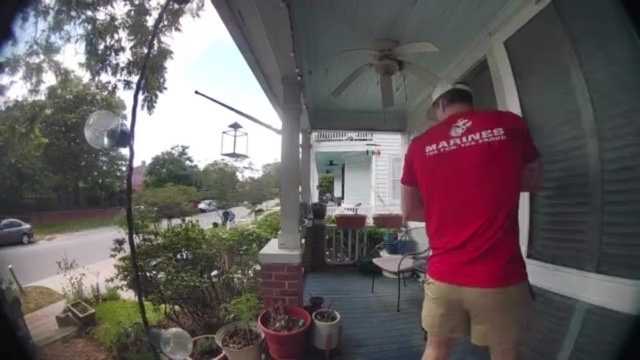

In [19]:
# Get the event id based on above structure
event_id = next(iter(events[0].get("resourceUpdate").get("events").values())).get("eventId")

generate_image_command = {"command": "sdm.devices.commands.generate_camera_event_image",
                          "params": {
                              "event_id": event_id
                              }
                          }
image_1 = sdm.execute_command(device_id=front_porch_cam_id, project_id=project_id, command_request=generate_image_command)

# ONLY FOR DEBUGGING
display_base64_image(image_1)

In [20]:
# Mock reply from Gemini
print("This image shows a brightly lit porch, with a man, thus assuming the man is Drake. \
It appears that Drake is putting something inside the mailbox. Therefore, I'll send a message to thank him on the slack channel.")

# Print the slack channels
slack_channels = slack.list_channels()
print(f"Slack channels: {slack_channels}")

This image shows a brightly lit porch, with a man, thus assuming the man is Drake. It appears that Drake is putting something inside the mailbox. Therefore, I'll send a message to thank him on the slack channel.
Slack channels: {'ok': True, 'channels': [{'messages': [{'ts': '1688682784.334459', 'user': 'U04L7NE5Q1Y', 'text': "Welcome everyone to the marketing brainstorming session!  Let's kick off by sharing any initial campaign ideas for Q3.", 'reactions': [{'name': 'rocket', 'users': ['U04L7NE5Q1Y', 'U04M2R8JCQ6', 'U04M526DV51'], 'count': 3}]}, {'ts': '1688683000.456789', 'user': 'U04M2R8JCQ6', 'text': 'I think we should focus on a social media campaign highlighting our sustainability initiatives.', 'reactions': [{'name': 'thumbsup', 'users': ['U04L7NE5Q1Y', 'U04M526DV51', 'U04LMCYSD2X'], 'count': 3}]}, {'ts': '1688684000.987654', 'user': 'U04LMCYSD2X', 'text': 'Has anyone seen those interactive ads on platform X?', 'reactions': []}], 'conversations': {}, 'name': 'Default_Channel', '

In [21]:
# Fetching the correct channel_id based on the slack_channel
channel_id = None
for channel in slack_channels['channels']:
    if channel.get("name") == slack_channel:
        channel_id = channel.get("id")
        break
print(channel_id)

# 5. Send message in the channel
slack.post_chat_message(channel_id, text=slack_message)

C8A67CA1A


{'ok': True,
 'message': {'channel': 'C8A67CA1A',
  'text': 'Thanks for putting the card in the mailbox, Drake! 😊',
  'attachments': None,
  'blocks': None,
  'user': 'bot',
  'ts': '1760443832.5167372',
  'as_user': None,
  'icon_emoji': None,
  'icon_url': None,
  'link_names': None,
  'markdown_text': None,
  'metadata': None,
  'mrkdwn': None,
  'parse': None,
  'reply_broadcast': None,
  'thread_ts': None,
  'unfurl_links': None,
  'unfurl_media': None,
  'username': None}}

# Final Assertion
1. Assert that 1 message has been sent in the "Family_Chat" channel with message body "Thanks for putting the card in the mailbox, Drake! 😊".
2. Assert that all the relevant images are utilized.

In [24]:
import sdm
import slack
from Scripts.assertions_utils import *

# Define context variables
slack_channel = "Family_Chat"
slack_message = "Thanks for putting the card in the mailbox, Drake! 😊"


# Helper functions
def are_all_images_used(expected_paths: list[str], served_type: str) -> bool:
    """Helper function to check if all expected images were used."""
    if not expected_paths:
        return True

    served_image_paths = sdm.devices.commands.get_served_images()

    if compare_strings(served_type, "event"):
        image_paths = served_image_paths.get("EVENT_IMAGES", [])
    elif compare_strings(served_type, "stream"):
        image_paths = served_image_paths.get("STREAM_IMAGES", [])
    else:
        print("Invalid served type.")
        return False

    if not image_paths:
        return True

    return compare_is_list_subset(expected_paths, image_paths, list_comparison_function="all")


# 1. Assert that exactly 1 message has been sent in the "Family_Chat" channel
#    with message body "Thanks for putting the card in the mailbox, Drake! 😊".
search_query = f"in:#{slack_channel} {slack_message}"
filtered_messages = slack.search_messages(search_query)
assert len(filtered_messages) == 1, (
    f"Found {len(filtered_messages)} Slack messages, expected 1."
)

# 2. Assert that all the relevant images are utilized.
# Collect expected image paths from the image map
image_map = sdm.load_image_map()
all_expected_paths = []
camera_image_entries = image_map.get("cameras", {})
event_image_entries = image_map.get("events", [])

for camera_id, image_entries in camera_image_entries.items():
    for entry in image_entries:
        if compare_strings(entry.get("expected", ""), "Yes"):
            all_expected_paths.append(entry.get("image_path"))

expected_event_paths = [event.get("image_path") for event in event_image_entries]
expected_stream_paths = [
    path for path in all_expected_paths if path not in expected_event_paths
]

assert are_all_images_used(expected_event_paths, "event"), (
    "Mismatch: Not all expected event images were used."
)
assert are_all_images_used(expected_stream_paths, "stream"), (
    "Mismatch: Not all expected stream images were used."
)
